<a href="https://colab.research.google.com/github/yankikalfa/SAIS-ML-for-Finance/blob/main/AutoCV_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 4: Automatic Cross Validation, Model Evaluation, Forecast Evaluation

## Objectives:

We are going to create a simple ML pipeline to forecast excess returns using Lasso and decision trees. We will select the hyperparamter, $\lambda$, using time series cross validation. Then we will analyze the model by charting the coefficients and hyperparameter over time. Finally, we will compare our forecasts to a benchmark.

You will use this pipeline for the in-class assignment.

# Libraries and Data

In [ ]:
! pip install statsmodels -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 4.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings("ignore")
plt.style.use('bmh')
plt.rcParams["figure.figsize"] = (16,8)

In [ ]:
df = pd.read_csv('GWdata.csv')
df['yyyymm'] = pd.to_datetime(df['yyyymm'],format='%Y%m', errors='coerce')
df.set_index('yyyymm',inplace=True)
df['er'] = df['CRSP_SPvw'] - df['Rfree']
df.drop(['CRSP_SPvw','Rfree','Index'],axis=1,inplace=True)
Y = df.loc['1927-01-01':,'er'].reset_index(drop=True)
X = df.loc[:'2021-11-01', df.columns!='er'].reset_index(drop=True)

# Automatic Time Series CV and Model Evaluation

The objective is to generate 1 step ahead forecasts for the last 10 years. We will update the hyperparamater every year using Time Series Cross Validation.

We will write a function to achieve the above defined objective.

In [ ]:
def timeseries_prediction_lasso(input_data, to_predict, cv_split, val_size, cc, n_jobs, max_iter=10000, return_alphas = False):
    """
    parameters:
    -----------
    input_data = data_frame of all input variables(X) to build the model
    to_predict = pandas series of output variables to build the model 
    cv = number of cross validation splits
    val_size = number of validation samples to predict on after each cross validation step
    start = initial number of input variables to consider
    alpha = regularizer value for model
    max_iter = maximum iterations to run while running the model
    
    returns:
    --------
    rmse_train = Return the train rmse of all the models
    rmse_test = Return the validation rmse of all the models
    r_squared = Return the r squared value of train set of all the models
    predicted_values = The predicted values over time by each model
    """
    scalerst =MinMaxScaler(feature_range=(-1,1))       
    start = cc
    x_new = input_data.loc[:start-1,]
    y_new = to_predict[:start]
    
    
    
    cv = TimeSeriesSplit(n_splits = cv_split, test_size= val_size)
    predicted_values = []
    
    rmse_cv = []
    rmse_train = []
    rmse_test = []
    r_squared = []
    alphas = []
    coef=[]
    
    
    for i in range(start,len(input_data)):
        x_new_tr=pd.DataFrame(scalerst.fit_transform(x_new))
        model = LassoCV(alphas=np.linspace(0.00001,0.1,1000),n_alphas=1000,cv=cv,n_jobs=n_jobs,max_iter=max_iter)
        results = model.fit(x_new_tr,y_new)

        
        best_alpha_index = np.where(results.alphas_==results.alpha_)[0][0]
        rmse_cv.append(results.mse_path_[best_alpha_index])
        alphas.append(model.alpha_)
        
        
        coef.append(results.coef_)
        prediction_train = results.predict(x_new_tr)
        
        prediction_test = results.predict(scalerst.transform(pd.DataFrame(input_data.loc[i]).T))
        
        r_squared.append(r2_score(y_new, prediction_train))
        rmse_train.append(mean_squared_error(y_new, prediction_train))
        
        
        start = i
        x_new = x_new.append(pd.DataFrame(input_data.loc[start]).T)
        y_new = y_new.append(pd.Series(to_predict[start]))
        predicted_values.append(prediction_test[0])
    
    rmse_test.append(mean_squared_error(to_predict[cc:], predicted_values))
    
    if return_alphas:
        return rmse_train, rmse_test, r_squared, predicted_values, rmse_cv, coef, alphas

    else:    
        return rmse_train, rmse_test, r_squared, predicted_values, rmse_cv,coef

In [ ]:
def timeseries_prediction_trees(input_data, to_predict, cc, param_dict, cv_split, val_size, n_jobs=-1, return_params = True):
    """
    parameters:
    -----------
    input_data = data_frame of all input variables(X) to build the model
    to_predict = pandas series of output variables to build the model 
    cv_model = number of cross validation splits
    val_size = number of validation samples to predict on after each cross validation step
    start = initial number of input variables to consider
    alpha = regularizer value for model
    max_iter = maximum iterations to run while running the model
    param_grid = parameter grids to search through
    
    returns:
    --------
    rmse_train = Return the train rmse of all the models
    rmse_test = Return the validation rmse of all the models
    r_squared = Return the r squared value of train set of all the models
    predicted_values = The predicted values over time by each model
    """
       
    scalerst =MinMaxScaler(feature_range=(-1,1))   
    start = cc
    x_new = input_data.loc[:start-1,]
    y_new = to_predict[:start]
    
    
    cv = TimeSeriesSplit(n_splits = cv_split, test_size= val_size)
    predicted_values = []
    
    rmse_cv = []
    rmse_train = []
    rmse_test = []
    r_squared = []
    params = []
    f_imp=[]
    
    for i in range(start,len(input_data)):
        x_new_tr=scalerst.fit_transform(x_new)
        model = GridSearchCV(DecisionTreeRegressor(), param_grid=param_dict, scoring = 'neg_root_mean_squared_error', cv = cv, n_jobs=n_jobs)
        results = model.fit(x_new_tr,y_new)
  
        
        rmse_cv.append(results.best_score_)
        params.append(results.best_params_)
        
        prediction_train = results.predict(x_new_tr)        
        start = i
        prediction_test = results.predict(scalerst.transform(pd.DataFrame(input_data.loc[i]).T))
        f_imp.append(results.best_estimator_.feature_importances_)
    
        r_squared.append(r2_score(y_new, prediction_train))
#        print(start)
        rmse_train.append(np.sqrt(mean_squared_error(y_new, prediction_train)))
        #rmse_test.append(np.sqrt(mean_squared_error(to_predict[start], prediction_test)))
        
        y_test= pd.Series(to_predict[start])
        predicted_values = predicted_values + list(prediction_test)
        x_new = x_new.append(pd.DataFrame(input_data.loc[start]).T)
        y_new = y_new.append(pd.Series(to_predict[start]))
    
#    r_squared_out_sample.append(r2_score(to_predict[input_data[input_data[split_column]<=cc].loc[:,columns].shape[0]:], predicted_values))
    rmse_test.append(mean_squared_error(to_predict[cc:], predicted_values))
    
    if return_params:
        return rmse_train, rmse_test, r_squared, predicted_values, rmse_cv, params, f_imp

    else:    
        return rmse_train, rmse_test, r_squared, predicted_values, rmse_cv, f_imp,

In [ ]:
lasso_rmse_train, lasso_rmse_test, lasso_r_squared, lasso_predicted_values, lasso_rmse_cv, lasso_coef,lasso_alphas = timeseries_prediction_lasso(X,Y,5,1,1020,-1,return_alphas=True)

In [ ]:
param_dict={'max_depth':[5,10,100],
            'min_samples_leaf':[5,10],
            'max_features':['auto','sqrt'],
            'ccp_alpha':[0,0.5,1]}
tree_rmse_train, tree_rmse_test, tree_r_squared, tree_predicted_values, tree_rmse_cv, tree_params,lasso_imp = timeseries_prediction_trees(X,Y,1020,param_dict,5,1,return_params=True)

## Model Evaluation

In [ ]:
lasso_coef=pd.DataFrame(lasso_coef)
lasso_coef.columns = X.columns
lasso_coef.set_index(df[-120:].index.copy(),inplace=True)

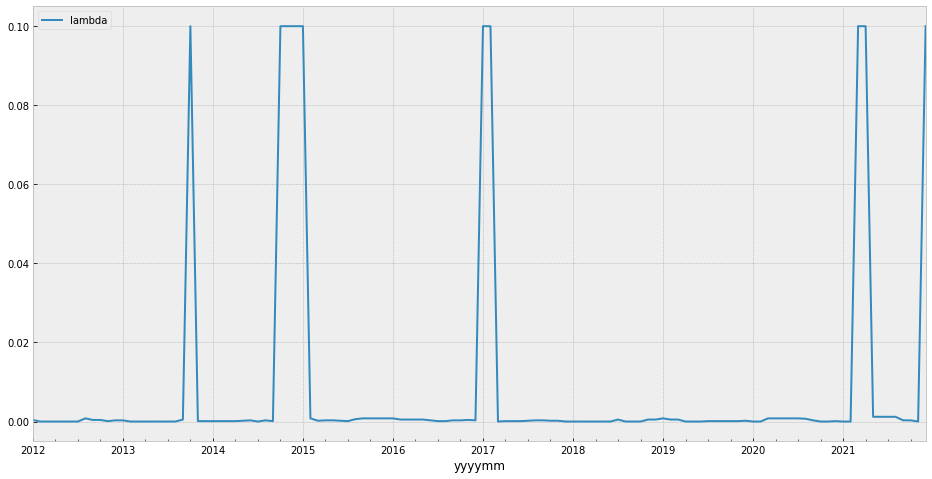

In [ ]:
lasso_hyper=pd.DataFrame(lasso_alphas)
lasso_hyper.columns=['lambda']
lasso_hyper.set_index(df[-120:].index.copy(),inplace=True)
lasso_hyper.plot()

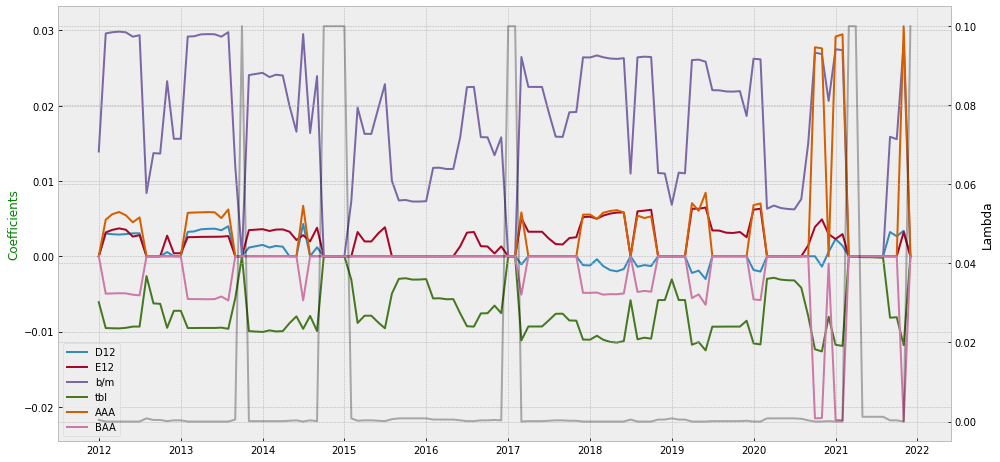

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(lasso_coef.iloc[:,:6])
ax2.plot(lasso_hyper,alpha=0.3,color='k')

ax1.set_ylabel('Coefficients', color='g')
ax1.legend(X.columns[:6])
ax2.set_ylabel('Lambda', color='k')

plt.show()

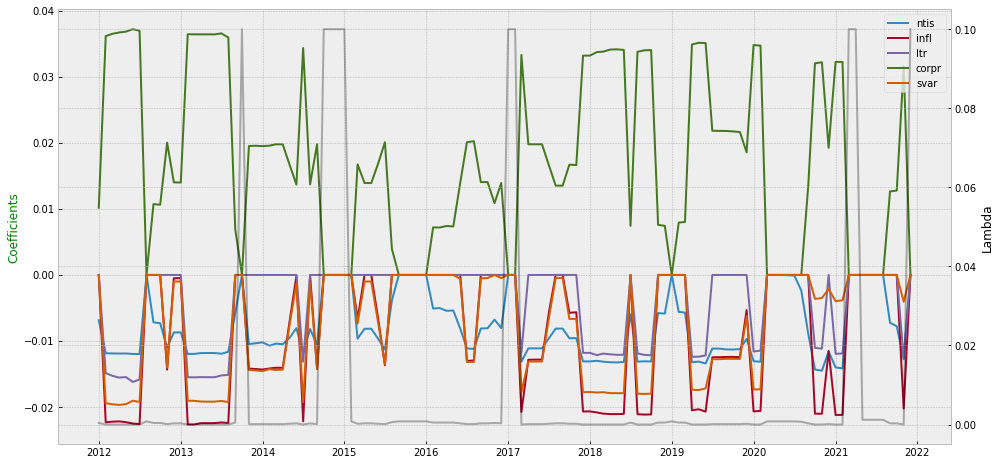

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(lasso_coef.iloc[:,7:])
ax2.plot(lasso_hyper,alpha=0.3,color='k')

ax1.set_ylabel('Coefficients', color='g')
ax1.legend(X.columns[7:])
ax2.set_ylabel('Lambda', color='k')

plt.show()

In [ ]:
trees_params=pd.DataFrame(tree_params)
trees_params.set_index(df[-120:].index.copy(),inplace=True)

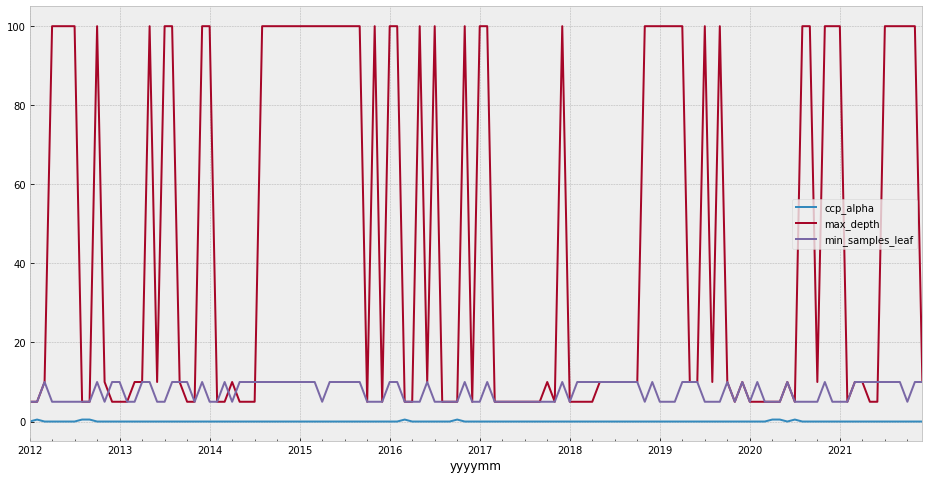

In [ ]:
trees_params.plot()

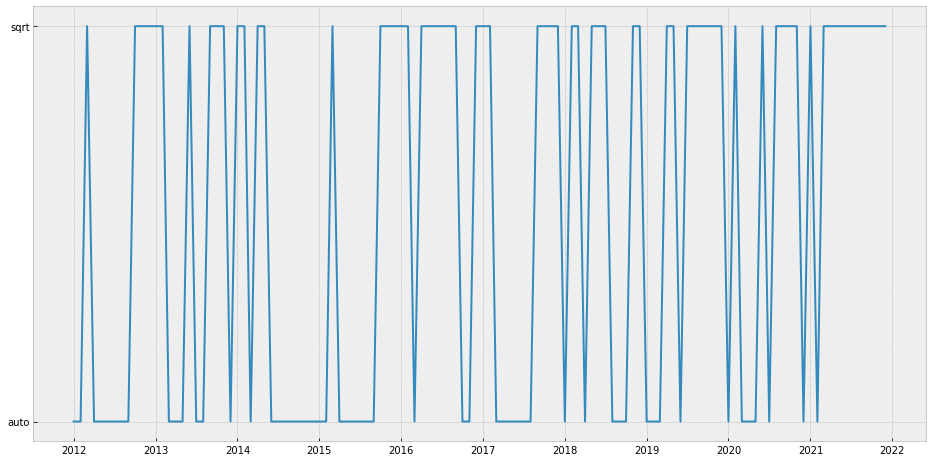

In [ ]:
plt.plot(trees_params['max_features'])

In [ ]:
trees_imp=pd.DataFrame(lasso_imp)
trees_imp.columns=X.columns
trees_imp.set_index(df[-120:].index.copy(),inplace=True)

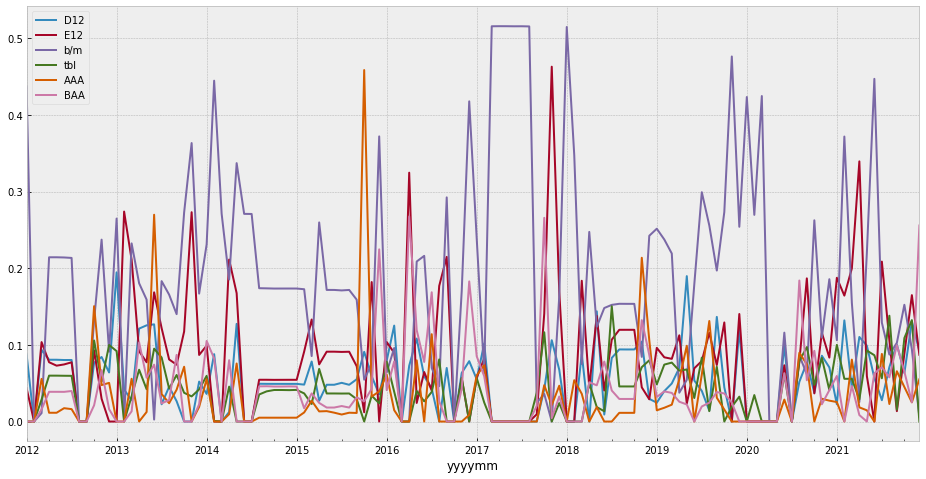

In [ ]:
trees_imp.iloc[:,:6].plot()

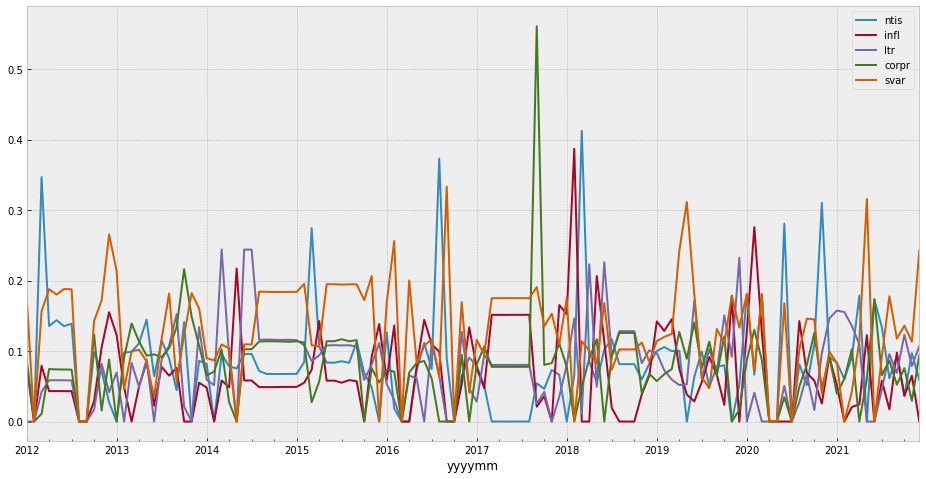

In [ ]:
trees_imp.iloc[:,7:].plot()

# Benchmarking

We need to select a benchmark to compare our forecasting model. We will choose the Prevailing Mean

In [ ]:
pmean_predictions =[]
for i in range(1021,len(df)):
        model = smf.ols('er~1', data=df.iloc[:i,:])
        results=model.fit()    
        pmean_predictions.append(results.params[0])

In [ ]:
prev_mean=pd.DataFrame(pmean_predictions)
prev_mean.columns=['PMean']
prev_mean.set_index(df[-120:].index.copy(),inplace=True)

In [ ]:
lasso_forecast=pd.DataFrame(lasso_predicted_values)
lasso_forecast.columns=['Lasso']
lasso_forecast.set_index(df[-120:].index.copy(),inplace=True)

In [ ]:
trees_forecast=pd.DataFrame(tree_predicted_values)
trees_forecast.columns=['Tree']
trees_forecast.set_index(df[-120:].index.copy(),inplace=True)

In [ ]:
actual=df['er'].iloc[-120:]

In [ ]:
forecasts=pd.concat([actual,lasso_forecast,trees_forecast,prev_mean],axis=1)
forecasts

,er,Lasso,Tree,PMean
yyyymm,,,,
2012-01-01,0.045205,0.010872,0.010635,0.006267
2012-02-01,0.043341,0.021233,0.006289,0.006305
2012-03-01,0.032866,0.020015,0.008045,0.006342
2012-04-01,-0.006034,0.009268,-0.023674,0.006367
2012-05-01,-0.059890,0.019174,-0.011208,0.006355
...,...,...,...,...
2021-08-01,0.030600,0.007003,0.011572,0.006942
2021-09-01,-0.046076,0.008404,0.028595,0.006962
2021-10-01,0.070510,0.006157,0.004269,0.006916


# Forecast Evaluation

In [ ]:
forecasts['e_lasso']=forecasts['er']-forecasts['Lasso']
forecasts['e_pmean']=forecasts['er']-forecasts['PMean']
forecasts['e_tree']=forecasts['er']-forecasts['Tree']

forecasts['e_2_lasso']=forecasts['e_lasso']**2
forecasts['e_2_pmean']=forecasts['e_pmean']**2
forecasts['e_2_tree']=forecasts['e_tree']**2

forecasts['dlasso']=forecasts['e_2_pmean']-forecasts['e_2_lasso']
forecasts['dtree']=forecasts['e_2_pmean']-forecasts['e_2_tree']

In [ ]:
forecasts.columns

Index(['er', 'Lasso', 'PMean', 'e_lasso', 'e_pmean', 'e_2_lasso', 'e_2_pmean',
       'd'],
      dtype='object')

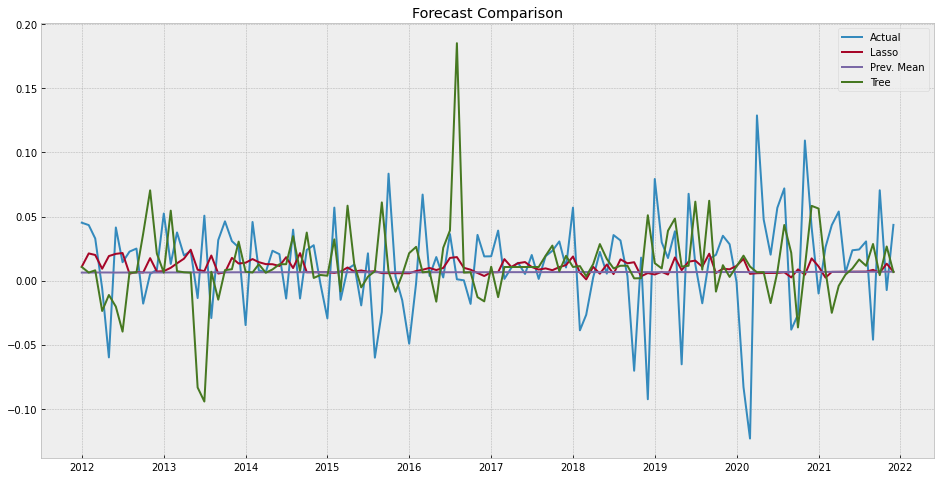

In [ ]:
plt.plot(forecasts['er'],label='Actual')
plt.plot(forecasts['Lasso'],label='Lasso')
plt.plot(forecasts['PMean'],label='Prev. Mean')
plt.plot(forecasts['Tree'],label='Tree')

plt.title('Forecast Comparison')
plt.legend()



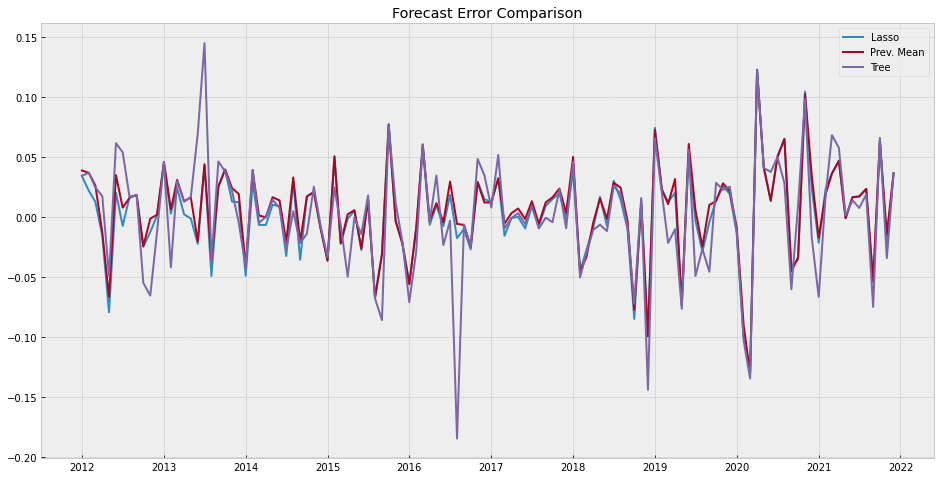

In [ ]:
plt.plot(forecasts['e_lasso'],label='Lasso')
plt.plot(forecasts['e_pmean'],label='Prev. Mean')
plt.plot(forecasts['e_tree'],label='Tree')
plt.title('Forecast Error Comparison')
plt.legend()


## Diebold Mariano Test

In [ ]:
dm = smf.ols('dlasso~1', data=forecasts).fit(cov_type='HAC',cov_kwds={'maxlags':1})
dm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 dlasso   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 02 Jul 2022   Prob (F-statistic):                nan
Time:                        03:39:03   Log-Likelihood:                 769.00
No. Observations:                 120   AIC:                            -1536.
Df Residuals:                     119   BIC:                            -1533.
Df Model:                           0                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7.628e-06   3.37e-05     -0.226      0.821   -7.37e-05    5.85e-05
==============================================================================
Omnibus:                       66.077   Durbin-Watson:                   2.278
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              422.695
Skew:                          -1.736   Prob(JB):                     1.63e-92
Kurtosis:                      11.514   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [ ]:
dm = smf.ols('dtree~1', data=forecasts).fit(cov_type='HAC',cov_kwds={'maxlags':1})
dm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  dtree   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 02 Jul 2022   Prob (F-statistic):                nan
Time:                        03:39:18   Log-Likelihood:                 498.12
No. Observations:                 120   AIC:                            -994.2
Df Residuals:                     119   BIC:                            -991.5
Df Model:                           0                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0009      0.000     -2.608      0.009      -0.002      -0.000
==============================================================================
Omnibus:                      191.763   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12681.805
Skew:                          -6.476   Prob(JB):                         0.00
Kurtosis:                      51.668   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

Note that we are using Newey West SE, and the p-value is larger than the standard significance levels for the Lasso. This is not the case for tree forecasts. The benchmark has superior forecast accuracy.

We conclude that the Lasso does not beat the benchmark.

We will now look at Out of Sample $R^2$ and Cumulative $\Delta$ SSE to see if there are any periods in which we beat the benchmark.

In [ ]:
OoSR2 = 1- np.mean(forecasts['e_2_lasso'])/np.mean(forecasts['e_2_pmean'])
round(OoSR2,4)

-0.0052

The Out of Sample $R^2$ is negative which suggest that the LASSO underperforms the prevailing mean.

Let's check Cumulative $\Delta$ SSE to see if there are any periods in which LASSO outperforms the Prevailing Mean.

In [ ]:
cumdsse_lasso=np.cumsum(forecasts.dlasso)
cumdsse_tree=np.cumsum(forecasts.dtree)


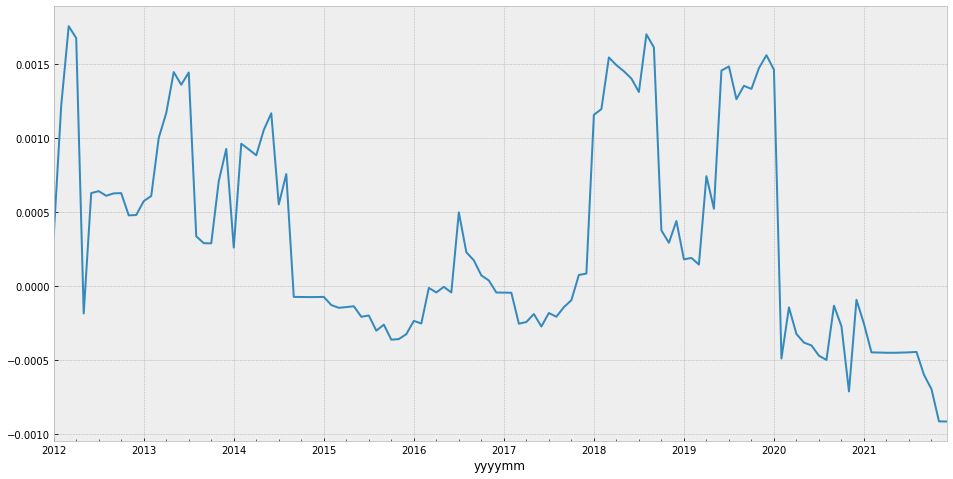

In [ ]:
cumdsse_lasso.plot()

The out of sample $R^2$ value we get is negative, however, the cumulative change in SSE error shows that until mid-2014 we have positive values, and increasing and positive values after 2018. We see a sharp decline starting in the beggining of 2020. This tell us that COVID had a great impact on the predictability of excess returns.

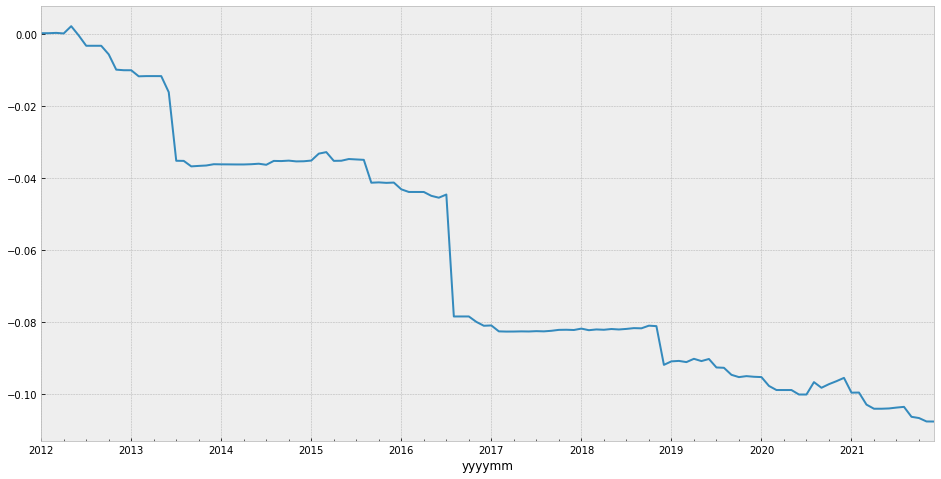

In [ ]:
cumdsse_tree.plot()